# Transferencia del aprendizaje y aumento de los datos.


En la actualidad, los modelos con mejor rendimiento en el campo del aprendizaje automático son las redes neuronales con una gran cantidad de parámetros, como se puede ver en algunos de los modelos disponibles en Keras ([Keras](https://keras.io/api/applications/)). Por ejemplo, se estima que el modelo ChatGPT cuenta con más de 175 mil millones de parámetros. Este tipo de modelos requieren grandes cantidades de datos y recursos computacionales para su entrenamiento, lo que puede resultar difícil de alcanzar para algunos. Se estima que Microsoft invirtió alrededor de 3 mil millones de dólares en la construcción del modelo ChatGPT (fuente: [New York Times](https://www.nytimes.com/2023/01/12/technology/microsoft-openai-chatgpt.html)).

Este hecho presenta un problema en el contexto de los científicos de datos, ya que a menudo no se cuenta con acceso a grandes cantidades de datos ni a la infraestructura computacional necesaria para el entrenamiento de modelos profundos. Sin embargo, existen alternativas que pueden adaptarse a cantidades moderadas de datos y requerir menos recursos computacionales, lo que las hace más accesibles y efectivas para muchos. Estas alternativas son dos: La transferencia del aprendizaje (Transfer Learning) y el aumento de los datos (Data Augmentation).

Los invito a que analicemos este código que implementa transferencia del aprendizaje y el aumento de los datos en la solución de un problema de clasificación de múltiples clases. Específicamente, se usa la base de datos [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=es-419) que configura un problema con 10 clases.

## Etapa 1: Carga de los datos

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
classNames = ['cat', 'dog']
split = ['train[:70%]', 'train[70%:]']
trainDataset, testDataset = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKE3ZJB/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


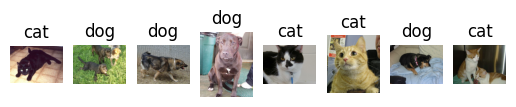

In [3]:
i = 0
fig, ax = plt.subplots(1, 8)
for image, label in testDataset.take(8):
    ax[i].axis('off')
    ax[i].set_title(classNames[label])
    ax[i].imshow(image)
    i += 1

plt.show()

## Etapa 2: Procesamiento de los datos 

Ahora, se normalizan los datos para que las imágenes tomen valores en el intervalo (0,1)

In [4]:
def preprocess(img, label):
    return tf.image.resize(img, [150, 150]) / 255, label

In [5]:
trainDataset, testDataset = trainDataset.map(preprocess).batch(32), testDataset.map(preprocess).batch(32)


## Etapa 3: Definición del modelo por transferencia del aprendizaje

La técnica de transfer learning consiste en aprovechar un modelo previamente entrenado y adaptarlo a nuestro problema de aprendizaje específico. De esta forma, se requiere una cantidad menor de datos para entrenar el modelo, lo que reduce el riesgo de sobreajuste y disminuye los requisitos de recursos computacionales.

In [6]:
# Primero, se carga el modelo pre-entrenado. Es una arquitectura VGG16, la cual 
# fue entrenada sobre la base de datos imagenet. Notemos que se fija el argumento 
# include_top=False, esto elimina la última capa de la red, la cual está relacionada 
# con la tarea de aprendizaje para la cual fue entrenada.

# De esta forma, debemos diseñar únicamente la últimas capas con el fin de que se
# adapten a nuestra aplicación, en este caso, una clasificación con 10 clases.
# Además, se debe fijar el argumento input_shape de tal forma que se adapte al 
# tamaño de nuestras imágenes. 

# En conclusión, esta red tiene más de 14 millones de parámetros. Sin embargo, 
# nosotros no entrenaremos todos estos parámetros, sino únicamente los de las 
# capas que diseñemos. Claramente esto reduce la cantidad necesaria de recursos 
# computacionales y la cantidad de datos. 
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [7]:
# Como hemos dicho, nosotros no vamos a entrenar todos los parámetros de la red,
# por esto, debemos indicarle al modelo que los parámetros del modelo base se
# dejarán en su forma actual.
base_model.trainable = False

In [8]:
# Ahora, debemos diseñar las capas superiores de la red, con el fin de que sean 
# las adecuadas para la tarea de aprendizaje planteada.
model = keras.Sequential([
    base_model, # se parte del modelo base.

    # Se agregan algunas capas para la tarea de aprendizaje. En este punto no se
    # suele usar capas convolucionales, solo capas densas y de pooling.
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    # la última capa debe corresponder a la tarea de aprendizaje. En este sentido,
    # dado que tenemos un problema de clasificación de 2 clases, usamos una capa
    # con una unidad y con activación Sigmoid.
    keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
# Se compila el modelo usando el optimizador ADAM, se fija una función de costo 
# basada en entropía cruzada y se evalúa el rendimiento en términos del accuracy.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# De los 16 millones de parámetros que tiene esta red, únicamente serán entrenados 
# 2 millones. Esto significa una reducción importante en la cantidad de datos y 
# por consiguiente en los recursos computacionales.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Ahora se compila, entrena y evalúa el modelo definido por transfer learning.

Epoch 1/20
509/509 [==============================] - 23s 19ms/step - loss: 0.3220 - accuracy: 0.8671 - val_loss: 0.2356 - val_accuracy: 0.9007
Epoch 2/20
509/509 [==============================] - 8s 16ms/step - loss: 0.2363 - accuracy: 0.9030 - val_loss: 0.2171 - val_accuracy: 0.9066
Epoch 3/20
509/509 [==============================] - 8s 16ms/step - loss: 0.2134 - accuracy: 0.9111 - val_loss: 0.2082 - val_accuracy: 0.9136
Epoch 4/20
509/509 [==============================] - 8s 17ms/step - loss: 0.1940 - accuracy: 0.9207 - val_loss: 0.2041 - val_accuracy: 0.9123
Epoch 5/20
509/509 [==============================] - 8s 16ms/step - loss: 0.1785 - accuracy: 0.9266 - val_loss: 0.2166 - val_accuracy: 0.9093
Epoch 6/20
509/509 [==============================] - 8s 16ms/step - loss: 0.1667 - accuracy: 0.9319 - val_loss: 0.2119 - val_accuracy: 0.9107
Epoch 7/20
509/509 [==============================] - 8s 17ms/step - loss: 0.1557 - accuracy: 0.9335 - val_loss: 0.2156 - val_accuracy: 0.910

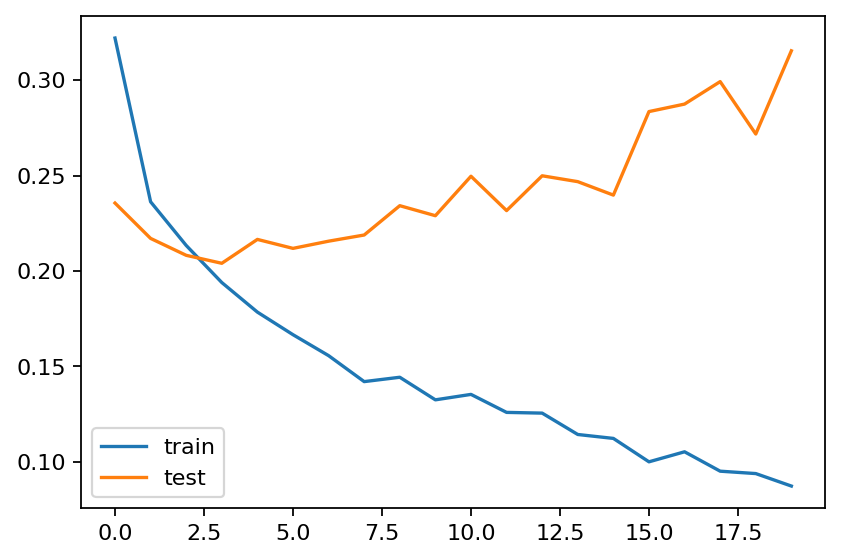

In [10]:
# Se entrena el modelo usando mini-lotes de tamaño 32, y el proceso de optimización
# se ejecuta para 20 épocas. (tarda alrededor de 20 minutos) 
history = model.fit(trainDataset, epochs=20, batch_size=32, validation_data=testDataset)

plt.figure(figsize=(6, 4), dpi=160)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

Al analizar las gráficas de la función de costo, se puede constatar que el modelo está experimentando el fenómeno de sobre-entrenamiento. A pesar de haber disminuido el número de parámetros que deben ser optimizados, la cantidad de estos parámetros sigue siendo considerablemente superior a la cantidad de datos de entrenamiento disponibles 

## 4. Incremento de los datos (Data Augmentation)

Para solucionar el problema del sobre-entrenamiento, hemos discutido diferentes estrategias como el dropout y la regularización. Otra alternativa consiste en generar imágenes sintéticas que corresponden a alteraciones de las imágenes del conjunto de entrenamiento.

In [11]:
# Primero, se reescalan las imágenes para que tengan un tamaño de 150x150
trainDataset, testDataset = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)
size = (150, 150)
trainDataset = trainDataset.map(lambda x, y: (tf.image.resize(x, size), y)).batch(32)
testDataset = testDataset.map(lambda x, y: (tf.image.resize(x, size), y)).batch(32)

In [12]:
# Se define un modelo para realizar el aumento de datos
data_augmentation = tf.keras.Sequential([
  # realiza cambios en la orientación de forma aleatoria
  keras.layers.RandomFlip("horizontal"),
  # Rota las imágenes de forma aleatoria
  keras.layers.RandomRotation(0.1),
])


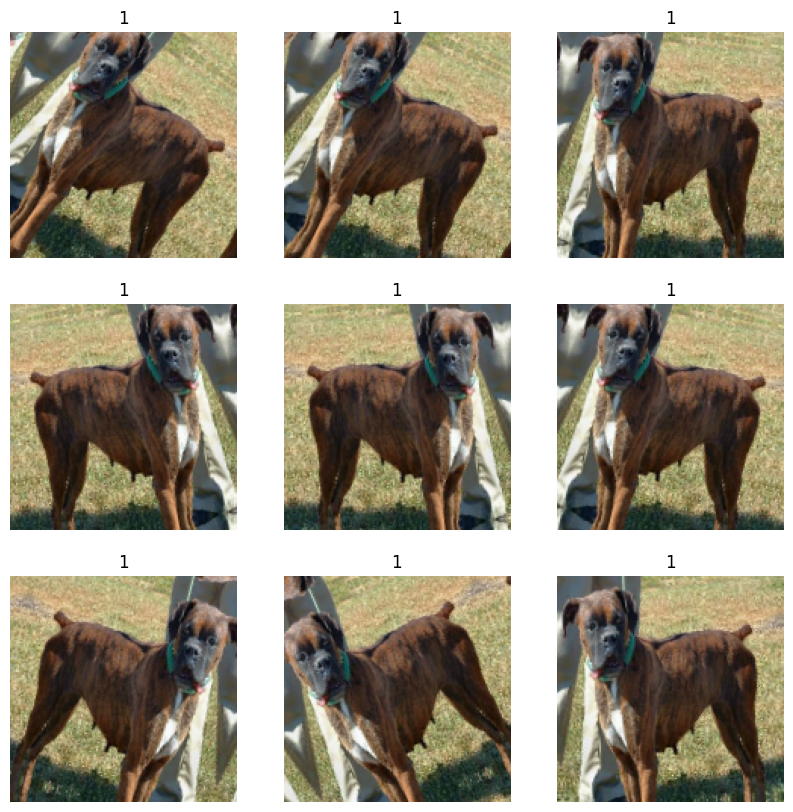

In [13]:
# Se visualizan algunas imágenes
import numpy as np

for images, labels in trainDataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [14]:
# Se modifica la red con el fin de usar los datos aumentados.

model_DA = keras.Sequential([
    # Se añade la función encargada del aumento de datos
    data_augmentation,
    base_model, 
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model_DA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model_DA.fit(trainDataset,
          epochs=20, 
          batch_size=32, 
          validation_data=testDataset) #tarda alrededor de 30 minutos

Epoch 1/20
509/509 [==============================] - 11s 18ms/step - loss: 0.7226 - accuracy: 0.8965 - val_loss: 0.1784 - val_accuracy: 0.9430
Epoch 2/20
509/509 [==============================] - 9s 17ms/step - loss: 0.2228 - accuracy: 0.9160 - val_loss: 0.1227 - val_accuracy: 0.9543
Epoch 3/20
509/509 [==============================] - 9s 17ms/step - loss: 0.1975 - accuracy: 0.9233 - val_loss: 0.1334 - val_accuracy: 0.9536
Epoch 4/20
509/509 [==============================] - 9s 17ms/step - loss: 0.1743 - accuracy: 0.9319 - val_loss: 0.1254 - val_accuracy: 0.9593
Epoch 5/20
509/509 [==============================] - 9s 17ms/step - loss: 0.1760 - accuracy: 0.9312 - val_loss: 0.1343 - val_accuracy: 0.9556
Epoch 6/20
509/509 [==============================] - 9s 17ms/step - loss: 0.1713 - accuracy: 0.9314 - val_loss: 0.1201 - val_accuracy: 0.9564
Epoch 7/20
509/509 [==============================] - 9s 17ms/step - loss: 0.1656 - accuracy: 0.9368 - val_loss: 0.1221 - val_accuracy: 0.959

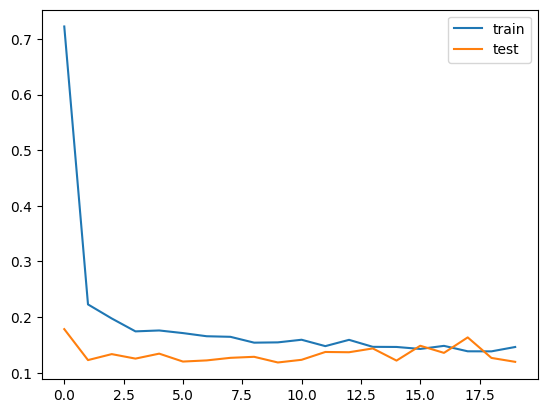

In [16]:
plt.plot(history1.history["loss"], label="train")
plt.plot(history1.history["val_loss"], label="test")
plt.legend()
plt.show()

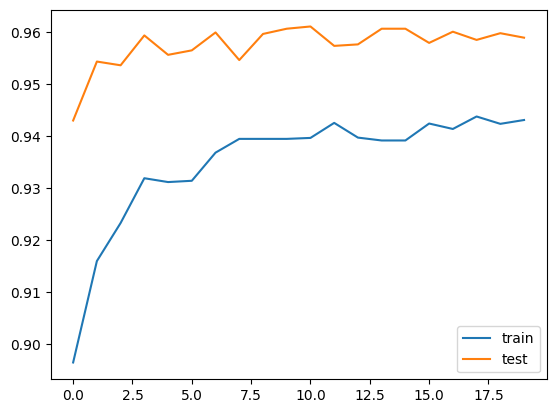

In [17]:
plt.plot(history1.history['accuracy'], label="train")
plt.plot(history1.history['val_accuracy'], label="test")
plt.legend()
plt.show()

# 4. Conclusión.

El aumento de datos y la transferencia de aprendizaje son dos elementos clave para cualquier científico de datos. Nos permiten aprovechar al máximo la capacidad de modelado de las redes neuronales profundas en situaciones en las que los datos etiquetados son escasos y cuando los recursos económicos no son suficientes para contar con potentes infraestructuras computacionales que permitan entrenar modelos con cientos de millones de parámetros.

La transferencia de aprendizaje nos permite utilizar modelos previamente entrenados en nuestras tareas, lo que reduce la cantidad de parámetros que deben ser estimados y, por lo tanto, la cantidad de datos necesarios para el entrenamiento y los requerimientos computacionales.

Por otro lado, el aumento de datos permite generar datos sintéticos a partir de los datos de entrenamiento, lo que aumenta el tamaño del conjunto de entrenamiento y disminuye el riesgo de overfitting.